In [2]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model, save_model
from keras.optimizers import Adam

import keras.backend as K
import tensorflow as tf
import pandas as pd

from sklearn.model_selection import train_test_split

from tqdm import tqdm
from json_tricks import dumps, loads
import pickle
import matplotlib.pyplot as plt

import sys

import numpy as np

/Users/gvsi/anaconda3/envs/gan/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
i = 0
lines = []
with open("data/data4_valid_mul5/fl4-mul5-comb-new.txt") as f:
    for line in f:
        lines.append(line)

In [4]:
Qs = []
for i in tqdm(range(len(lines))):
    map_str_comb, dic = lines[i].split("\t")
    obj = loads(dic)
    Qs.append(obj['Q'])

100%|██████████| 3828/3828 [00:19<00:00, 199.11it/s]


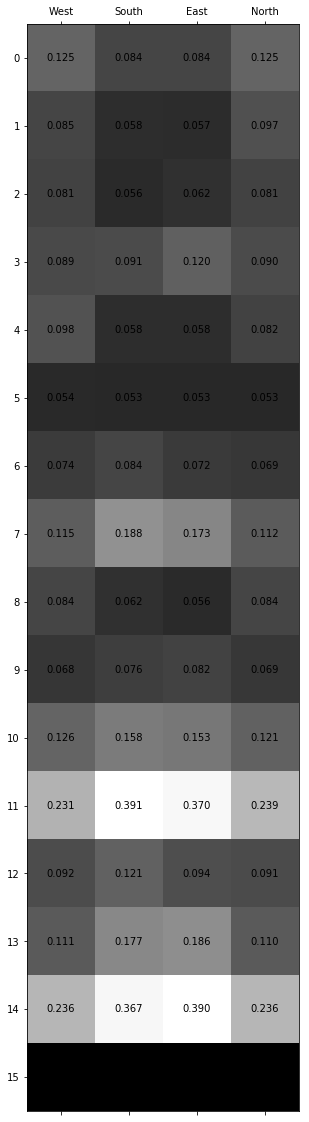

In [37]:
data = pd.DataFrame(np.array([list(q.flatten()) for q in Qs]))
fig, ax = plt.subplots(figsize=(40, 20))

dat = np.array(data.describe().loc['mean']).reshape((16,4))
ax.matshow(dat, cmap='Greys_r')
# ax.set_xticks(np.arange(10), minor=False)
# labels = [item.get_text() for item in ax.get_xticklabels()]
# print(labels)
# labels[0] = 'West'
# labels[1] = 'South'
# labels[2] = 'East'
# labels[3] = 'Up'
# labels[4] = 'North'
# print(labels)
labels = ['','West', 'South', 'East', 'North']
ax.set_xticklabels(labels)

ax.set_yticks(np.arange(dat.shape[0]), minor=False)
for (i, j), z in np.ndenumerate(dat):
    ax.text(j, i, '{:0.3f}'.format(z), ha='center', va='center')

fig.savefig("Qtable_mean.pdf", bbox_inches='tight')


In [13]:
q_data = np.array([q for q in Qs])

In [14]:
X_train, X_test = train_test_split(q_data, test_size=0.10, random_state=42)

In [15]:
X_train.shape

(3445, 16, 4)

In [136]:
class GAN():
    def __init__(self):
        self.img_rows = 16
        self.img_cols = 4
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', 
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)

        # The generator takes noise as input and generated imgs
        z = Input(shape=(100,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity 
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        noise_shape = (100,)
        
        model = Sequential()

        model.add(Dense(256, input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)
        
        model = Sequential()

        model.add(Flatten(input_shape=img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):
        global X_train
        # Load the dataset
#         (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
#         X_train = (X_train.astype(np.float32) - 127.5) / 127.5
#         print(X_train.shape)
        X_train2 = np.expand_dims(X_train, axis=3)
#         print(X_train.shape)
        half_batch = int(batch_size / 2)

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train2.shape[0], half_batch)
            imgs = X_train2[idx]
#             print(imgs[0].shape)

            noise = np.random.normal(0, 1, (half_batch, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = np.array([1] * batch_size)

            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("out/keras/mnist_%d.png" % epoch)
        plt.close()

In [141]:
gan = GAN()
gan.train(epochs=2000, batch_size=32, save_interval=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_12 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_78 (Dense)             (None, 512)               33280     
_________________________________________________________________
leaky_re_lu_56 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_79 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_57 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_80 (Dense)             (None, 1)                 257       
Total params: 164,865
Trainable params: 164,865
Non-trainable params: 0
_________________________________________________________________
____

/Users/gvsi/anaconda3/envs/gan/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.713444, acc.: 21.88%] [G loss: 0.696782]
1 [D loss: 0.702883, acc.: 50.00%] [G loss: 0.731624]
2 [D loss: 0.651850, acc.: 81.25%] [G loss: 0.802202]
3 [D loss: 0.641305, acc.: 78.12%] [G loss: 0.892761]
4 [D loss: 0.591117, acc.: 84.38%] [G loss: 0.965578]
5 [D loss: 0.551623, acc.: 96.88%] [G loss: 1.053038]
6 [D loss: 0.551161, acc.: 84.38%] [G loss: 1.105906]
7 [D loss: 0.513857, acc.: 87.50%] [G loss: 1.131483]
8 [D loss: 0.513615, acc.: 96.88%] [G loss: 1.192859]
9 [D loss: 0.476016, acc.: 93.75%] [G loss: 1.247323]
10 [D loss: 0.484904, acc.: 93.75%] [G loss: 1.253794]
11 [D loss: 0.476447, acc.: 100.00%] [G loss: 1.377658]
12 [D loss: 0.421851, acc.: 96.88%] [G loss: 1.432827]
13 [D loss: 0.448278, acc.: 93.75%] [G loss: 1.490080]
14 [D loss: 0.461930, acc.: 90.62%] [G loss: 1.547501]
15 [D loss: 0.427093, acc.: 96.88%] [G loss: 1.630477]
16 [D loss: 0.429930, acc.: 100.00%] [G loss: 1.665815]
17 [D loss: 0.354885, acc.: 100.00%] [G loss: 1.739450]
18 [D loss: 0.384

156 [D loss: 0.197159, acc.: 100.00%] [G loss: 2.839592]
157 [D loss: 0.152138, acc.: 100.00%] [G loss: 3.037093]
158 [D loss: 0.197725, acc.: 96.88%] [G loss: 3.238239]
159 [D loss: 0.155616, acc.: 100.00%] [G loss: 3.359367]
160 [D loss: 0.159415, acc.: 100.00%] [G loss: 3.468818]
161 [D loss: 0.173961, acc.: 100.00%] [G loss: 3.332149]
162 [D loss: 0.131365, acc.: 100.00%] [G loss: 3.345062]
163 [D loss: 0.170753, acc.: 100.00%] [G loss: 3.393987]
164 [D loss: 0.200513, acc.: 96.88%] [G loss: 3.236291]
165 [D loss: 0.152885, acc.: 100.00%] [G loss: 3.720093]
166 [D loss: 0.225378, acc.: 96.88%] [G loss: 3.274955]
167 [D loss: 0.181204, acc.: 96.88%] [G loss: 3.114576]
168 [D loss: 0.148644, acc.: 100.00%] [G loss: 3.016943]
169 [D loss: 0.180875, acc.: 100.00%] [G loss: 2.980849]
170 [D loss: 0.161804, acc.: 100.00%] [G loss: 3.161316]
171 [D loss: 0.162677, acc.: 100.00%] [G loss: 3.375694]
172 [D loss: 0.149085, acc.: 100.00%] [G loss: 3.399035]
173 [D loss: 0.200188, acc.: 96.88%

309 [D loss: 0.107146, acc.: 96.88%] [G loss: 3.076979]
310 [D loss: 0.082447, acc.: 100.00%] [G loss: 3.292109]
311 [D loss: 0.058409, acc.: 100.00%] [G loss: 3.781900]
312 [D loss: 0.051409, acc.: 100.00%] [G loss: 4.136866]
313 [D loss: 0.065079, acc.: 96.88%] [G loss: 4.743723]
314 [D loss: 0.048738, acc.: 100.00%] [G loss: 4.709964]
315 [D loss: 0.072750, acc.: 96.88%] [G loss: 4.216004]
316 [D loss: 0.045746, acc.: 100.00%] [G loss: 4.597557]
317 [D loss: 0.090310, acc.: 100.00%] [G loss: 3.797522]
318 [D loss: 0.069194, acc.: 100.00%] [G loss: 3.979646]
319 [D loss: 0.092037, acc.: 100.00%] [G loss: 4.380751]
320 [D loss: 0.040299, acc.: 100.00%] [G loss: 4.822367]
321 [D loss: 0.027781, acc.: 100.00%] [G loss: 4.823944]
322 [D loss: 0.037866, acc.: 100.00%] [G loss: 4.586406]
323 [D loss: 0.056880, acc.: 100.00%] [G loss: 4.490052]
324 [D loss: 0.063158, acc.: 100.00%] [G loss: 4.205150]
325 [D loss: 0.111113, acc.: 96.88%] [G loss: 4.156002]
326 [D loss: 0.045186, acc.: 100.00

454 [D loss: 0.094109, acc.: 96.88%] [G loss: 4.255908]
455 [D loss: 0.072878, acc.: 100.00%] [G loss: 4.698192]
456 [D loss: 0.123266, acc.: 96.88%] [G loss: 4.120411]
457 [D loss: 0.049543, acc.: 100.00%] [G loss: 4.327510]
458 [D loss: 0.086477, acc.: 100.00%] [G loss: 4.278182]
459 [D loss: 0.052684, acc.: 100.00%] [G loss: 4.367252]
460 [D loss: 0.074195, acc.: 100.00%] [G loss: 4.056006]
461 [D loss: 0.055987, acc.: 100.00%] [G loss: 4.205205]
462 [D loss: 0.131586, acc.: 93.75%] [G loss: 4.489791]
463 [D loss: 0.094941, acc.: 96.88%] [G loss: 4.406270]
464 [D loss: 0.108121, acc.: 96.88%] [G loss: 4.168258]
465 [D loss: 0.063129, acc.: 100.00%] [G loss: 4.266055]
466 [D loss: 0.081666, acc.: 96.88%] [G loss: 4.116098]
467 [D loss: 0.068169, acc.: 100.00%] [G loss: 3.917483]
468 [D loss: 0.102568, acc.: 96.88%] [G loss: 4.273647]
469 [D loss: 0.093369, acc.: 96.88%] [G loss: 4.423981]
470 [D loss: 0.033630, acc.: 100.00%] [G loss: 5.117645]
471 [D loss: 0.117127, acc.: 93.75%] [G

601 [D loss: 0.127199, acc.: 100.00%] [G loss: 4.063871]
602 [D loss: 0.400720, acc.: 81.25%] [G loss: 4.006715]
603 [D loss: 0.175107, acc.: 96.88%] [G loss: 3.831855]
604 [D loss: 0.218517, acc.: 90.62%] [G loss: 4.062304]
605 [D loss: 0.192240, acc.: 93.75%] [G loss: 3.811949]
606 [D loss: 0.194497, acc.: 93.75%] [G loss: 4.202737]
607 [D loss: 0.385657, acc.: 84.38%] [G loss: 3.778326]
608 [D loss: 0.448696, acc.: 75.00%] [G loss: 3.468464]
609 [D loss: 0.240758, acc.: 87.50%] [G loss: 3.836839]
610 [D loss: 0.347007, acc.: 93.75%] [G loss: 3.290914]
611 [D loss: 0.286191, acc.: 81.25%] [G loss: 4.513768]
612 [D loss: 0.218462, acc.: 90.62%] [G loss: 4.524728]
613 [D loss: 0.471371, acc.: 71.88%] [G loss: 3.100836]
614 [D loss: 0.201097, acc.: 90.62%] [G loss: 4.400710]
615 [D loss: 0.334355, acc.: 84.38%] [G loss: 4.036004]
616 [D loss: 0.307860, acc.: 84.38%] [G loss: 3.797353]
617 [D loss: 0.257123, acc.: 87.50%] [G loss: 3.462914]
618 [D loss: 0.380614, acc.: 81.25%] [G loss: 3

754 [D loss: 0.681508, acc.: 65.62%] [G loss: 2.250392]
755 [D loss: 0.727110, acc.: 53.12%] [G loss: 2.042933]
756 [D loss: 0.743177, acc.: 56.25%] [G loss: 2.193949]
757 [D loss: 0.735052, acc.: 59.38%] [G loss: 1.765880]
758 [D loss: 0.302910, acc.: 90.62%] [G loss: 2.414875]
759 [D loss: 0.624283, acc.: 62.50%] [G loss: 2.189010]
760 [D loss: 0.538732, acc.: 68.75%] [G loss: 2.386539]
761 [D loss: 0.690747, acc.: 65.62%] [G loss: 2.073713]
762 [D loss: 0.523821, acc.: 75.00%] [G loss: 2.495678]
763 [D loss: 0.566812, acc.: 65.62%] [G loss: 1.527356]
764 [D loss: 0.565644, acc.: 65.62%] [G loss: 1.821401]
765 [D loss: 0.420748, acc.: 87.50%] [G loss: 1.807433]
766 [D loss: 0.605036, acc.: 68.75%] [G loss: 2.151347]
767 [D loss: 0.778852, acc.: 68.75%] [G loss: 2.697228]
768 [D loss: 0.629423, acc.: 65.62%] [G loss: 2.823622]
769 [D loss: 0.905745, acc.: 46.88%] [G loss: 1.799110]
770 [D loss: 0.723390, acc.: 59.38%] [G loss: 2.280160]
771 [D loss: 0.593345, acc.: 71.88%] [G loss: 2.

908 [D loss: 0.899195, acc.: 40.62%] [G loss: 0.950052]
909 [D loss: 0.818671, acc.: 53.12%] [G loss: 1.175246]
910 [D loss: 1.152766, acc.: 40.62%] [G loss: 1.215286]
911 [D loss: 0.950637, acc.: 37.50%] [G loss: 0.912409]
912 [D loss: 0.859860, acc.: 34.38%] [G loss: 1.075347]
913 [D loss: 0.951028, acc.: 37.50%] [G loss: 0.965937]
914 [D loss: 0.701885, acc.: 56.25%] [G loss: 1.062518]
915 [D loss: 0.702232, acc.: 59.38%] [G loss: 1.457254]
916 [D loss: 0.762685, acc.: 40.62%] [G loss: 1.247143]
917 [D loss: 0.921496, acc.: 37.50%] [G loss: 1.312533]
918 [D loss: 0.928185, acc.: 40.62%] [G loss: 1.057914]
919 [D loss: 0.978173, acc.: 43.75%] [G loss: 0.920724]
920 [D loss: 0.871055, acc.: 43.75%] [G loss: 0.871298]
921 [D loss: 0.952098, acc.: 34.38%] [G loss: 0.822783]
922 [D loss: 0.939626, acc.: 34.38%] [G loss: 0.927801]
923 [D loss: 0.706750, acc.: 53.12%] [G loss: 1.019234]
924 [D loss: 0.825699, acc.: 37.50%] [G loss: 0.974693]
925 [D loss: 0.763299, acc.: 53.12%] [G loss: 1.

1056 [D loss: 0.898219, acc.: 12.50%] [G loss: 0.781045]
1057 [D loss: 0.695710, acc.: 50.00%] [G loss: 0.764166]
1058 [D loss: 0.853397, acc.: 34.38%] [G loss: 0.748097]
1059 [D loss: 0.912385, acc.: 21.88%] [G loss: 0.734480]
1060 [D loss: 0.871505, acc.: 28.12%] [G loss: 0.812953]
1061 [D loss: 0.838361, acc.: 34.38%] [G loss: 0.726968]
1062 [D loss: 0.717216, acc.: 46.88%] [G loss: 0.713730]
1063 [D loss: 0.692530, acc.: 53.12%] [G loss: 0.820687]
1064 [D loss: 0.763741, acc.: 43.75%] [G loss: 0.866987]
1065 [D loss: 0.796116, acc.: 34.38%] [G loss: 0.773221]
1066 [D loss: 0.894394, acc.: 28.12%] [G loss: 0.751968]
1067 [D loss: 0.815776, acc.: 34.38%] [G loss: 0.747363]
1068 [D loss: 0.779224, acc.: 37.50%] [G loss: 0.811276]
1069 [D loss: 0.765009, acc.: 37.50%] [G loss: 0.813198]
1070 [D loss: 0.684671, acc.: 53.12%] [G loss: 0.908509]
1071 [D loss: 0.667681, acc.: 59.38%] [G loss: 0.851359]
1072 [D loss: 0.741477, acc.: 37.50%] [G loss: 0.849164]
1073 [D loss: 0.721371, acc.: 4

1201 [D loss: 0.704116, acc.: 56.25%] [G loss: 0.711202]
1202 [D loss: 0.727808, acc.: 37.50%] [G loss: 0.722048]
1203 [D loss: 0.692060, acc.: 50.00%] [G loss: 0.793062]
1204 [D loss: 0.792057, acc.: 31.25%] [G loss: 0.760528]
1205 [D loss: 0.768535, acc.: 34.38%] [G loss: 0.678531]
1206 [D loss: 0.749635, acc.: 37.50%] [G loss: 0.639985]
1207 [D loss: 0.759590, acc.: 31.25%] [G loss: 0.760291]
1208 [D loss: 0.765369, acc.: 31.25%] [G loss: 0.691760]
1209 [D loss: 0.765255, acc.: 37.50%] [G loss: 0.690184]
1210 [D loss: 0.741788, acc.: 37.50%] [G loss: 0.653440]
1211 [D loss: 0.791702, acc.: 28.12%] [G loss: 0.627096]
1212 [D loss: 0.726252, acc.: 46.88%] [G loss: 0.624908]
1213 [D loss: 0.728309, acc.: 43.75%] [G loss: 0.643421]
1214 [D loss: 0.770358, acc.: 31.25%] [G loss: 0.643812]
1215 [D loss: 0.725793, acc.: 43.75%] [G loss: 0.654641]
1216 [D loss: 0.759119, acc.: 34.38%] [G loss: 0.639589]
1217 [D loss: 0.751030, acc.: 40.62%] [G loss: 0.671734]
1218 [D loss: 0.735963, acc.: 3

1355 [D loss: 0.730095, acc.: 37.50%] [G loss: 0.757360]
1356 [D loss: 0.693820, acc.: 53.12%] [G loss: 0.738188]
1357 [D loss: 0.724230, acc.: 40.62%] [G loss: 0.803093]
1358 [D loss: 0.710244, acc.: 46.88%] [G loss: 0.764706]
1359 [D loss: 0.725016, acc.: 43.75%] [G loss: 0.734674]
1360 [D loss: 0.746408, acc.: 34.38%] [G loss: 0.733510]
1361 [D loss: 0.736340, acc.: 34.38%] [G loss: 0.734919]
1362 [D loss: 0.771790, acc.: 28.12%] [G loss: 0.648348]
1363 [D loss: 0.755610, acc.: 37.50%] [G loss: 0.696806]
1364 [D loss: 0.714080, acc.: 34.38%] [G loss: 0.715429]
1365 [D loss: 0.741863, acc.: 34.38%] [G loss: 0.666573]
1366 [D loss: 0.726079, acc.: 37.50%] [G loss: 0.650630]
1367 [D loss: 0.742297, acc.: 43.75%] [G loss: 0.700541]
1368 [D loss: 0.759207, acc.: 28.12%] [G loss: 0.671325]
1369 [D loss: 0.699052, acc.: 59.38%] [G loss: 0.676847]
1370 [D loss: 0.727176, acc.: 34.38%] [G loss: 0.773948]
1371 [D loss: 0.750892, acc.: 34.38%] [G loss: 0.728501]
1372 [D loss: 0.736143, acc.: 4

1512 [D loss: 0.750208, acc.: 34.38%] [G loss: 0.699284]
1513 [D loss: 0.727138, acc.: 37.50%] [G loss: 0.691338]
1514 [D loss: 0.700689, acc.: 46.88%] [G loss: 0.697098]
1515 [D loss: 0.755569, acc.: 18.75%] [G loss: 0.691317]
1516 [D loss: 0.718924, acc.: 34.38%] [G loss: 0.699650]
1517 [D loss: 0.716742, acc.: 40.62%] [G loss: 0.685441]
1518 [D loss: 0.705675, acc.: 43.75%] [G loss: 0.682209]
1519 [D loss: 0.724857, acc.: 37.50%] [G loss: 0.743675]
1520 [D loss: 0.693894, acc.: 53.12%] [G loss: 0.750861]
1521 [D loss: 0.703804, acc.: 43.75%] [G loss: 0.707592]
1522 [D loss: 0.731023, acc.: 34.38%] [G loss: 0.708717]
1523 [D loss: 0.695063, acc.: 34.38%] [G loss: 0.763185]
1524 [D loss: 0.725879, acc.: 40.62%] [G loss: 0.738848]
1525 [D loss: 0.755590, acc.: 18.75%] [G loss: 0.742790]
1526 [D loss: 0.704648, acc.: 34.38%] [G loss: 0.733728]
1527 [D loss: 0.688972, acc.: 56.25%] [G loss: 0.754246]
1528 [D loss: 0.736055, acc.: 28.12%] [G loss: 0.745791]
1529 [D loss: 0.712453, acc.: 5

1668 [D loss: 0.711575, acc.: 37.50%] [G loss: 0.721797]
1669 [D loss: 0.725163, acc.: 40.62%] [G loss: 0.697061]
1670 [D loss: 0.694182, acc.: 40.62%] [G loss: 0.711055]
1671 [D loss: 0.682727, acc.: 59.38%] [G loss: 0.730107]
1672 [D loss: 0.703870, acc.: 43.75%] [G loss: 0.729207]
1673 [D loss: 0.723780, acc.: 25.00%] [G loss: 0.718081]
1674 [D loss: 0.702454, acc.: 46.88%] [G loss: 0.724381]
1675 [D loss: 0.695852, acc.: 46.88%] [G loss: 0.771811]
1676 [D loss: 0.679133, acc.: 65.62%] [G loss: 0.740512]
1677 [D loss: 0.713437, acc.: 34.38%] [G loss: 0.733570]
1678 [D loss: 0.709715, acc.: 46.88%] [G loss: 0.718858]
1679 [D loss: 0.726315, acc.: 37.50%] [G loss: 0.719137]
1680 [D loss: 0.694440, acc.: 43.75%] [G loss: 0.748353]
1681 [D loss: 0.712243, acc.: 53.12%] [G loss: 0.726393]
1682 [D loss: 0.700614, acc.: 46.88%] [G loss: 0.702958]
1683 [D loss: 0.682330, acc.: 59.38%] [G loss: 0.699879]
1684 [D loss: 0.715172, acc.: 46.88%] [G loss: 0.709019]
1685 [D loss: 0.706102, acc.: 5

1815 [D loss: 0.695712, acc.: 53.12%] [G loss: 0.722291]
1816 [D loss: 0.716870, acc.: 37.50%] [G loss: 0.701316]
1817 [D loss: 0.699994, acc.: 43.75%] [G loss: 0.716145]
1818 [D loss: 0.725973, acc.: 40.62%] [G loss: 0.712903]
1819 [D loss: 0.669429, acc.: 71.88%] [G loss: 0.716301]
1820 [D loss: 0.704700, acc.: 50.00%] [G loss: 0.708236]
1821 [D loss: 0.704370, acc.: 53.12%] [G loss: 0.718824]
1822 [D loss: 0.730729, acc.: 37.50%] [G loss: 0.733598]
1823 [D loss: 0.694169, acc.: 50.00%] [G loss: 0.728585]
1824 [D loss: 0.675331, acc.: 56.25%] [G loss: 0.789536]
1825 [D loss: 0.709580, acc.: 37.50%] [G loss: 0.741279]
1826 [D loss: 0.688201, acc.: 62.50%] [G loss: 0.785395]
1827 [D loss: 0.701073, acc.: 43.75%] [G loss: 0.743051]
1828 [D loss: 0.680048, acc.: 56.25%] [G loss: 0.791724]
1829 [D loss: 0.708953, acc.: 56.25%] [G loss: 0.761327]
1830 [D loss: 0.685274, acc.: 65.62%] [G loss: 0.789645]
1831 [D loss: 0.710203, acc.: 37.50%] [G loss: 0.772366]
1832 [D loss: 0.668969, acc.: 6

1967 [D loss: 0.700563, acc.: 46.88%] [G loss: 0.760015]
1968 [D loss: 0.701276, acc.: 50.00%] [G loss: 0.771436]
1969 [D loss: 0.706144, acc.: 46.88%] [G loss: 0.727067]
1970 [D loss: 0.691873, acc.: 53.12%] [G loss: 0.755194]
1971 [D loss: 0.710789, acc.: 43.75%] [G loss: 0.748294]
1972 [D loss: 0.666974, acc.: 59.38%] [G loss: 0.771930]
1973 [D loss: 0.724423, acc.: 28.12%] [G loss: 0.755240]
1974 [D loss: 0.694352, acc.: 53.12%] [G loss: 0.777824]
1975 [D loss: 0.681101, acc.: 50.00%] [G loss: 0.767030]
1976 [D loss: 0.736477, acc.: 28.12%] [G loss: 0.735053]
1977 [D loss: 0.724300, acc.: 46.88%] [G loss: 0.718327]
1978 [D loss: 0.684257, acc.: 46.88%] [G loss: 0.747793]
1979 [D loss: 0.675109, acc.: 46.88%] [G loss: 0.764950]
1980 [D loss: 0.687630, acc.: 53.12%] [G loss: 0.755016]
1981 [D loss: 0.717951, acc.: 34.38%] [G loss: 0.753265]
1982 [D loss: 0.707681, acc.: 40.62%] [G loss: 0.749555]
1983 [D loss: 0.691230, acc.: 50.00%] [G loss: 0.746134]
1984 [D loss: 0.688864, acc.: 5

In [142]:
gan.discriminator.save("data/gan/D_params_keras.p")
gan.generator.save("data/gan/G_params_keras.p")

In [143]:
X_test2 = np.expand_dims(X_test, axis=3)

In [144]:
gan.discriminator.predict(X_test2).mean()

0.47819036

In [145]:
output = gan.discriminator.outputs[-1]
g

<tf.Tensor 'sequential_23/dense_80/Sigmoid:0' shape=(?, 1) dtype=float32>

In [196]:
loss = (1 - output) ** 2

In [197]:
# x = tf.placeholder(dtype=tf.float32, shape=(16,4,1))
grad = K.gradients(loss, gan.discriminator.inputs[-1])

In [198]:
input_tensors = [gan.discriminator.inputs[0]]

In [199]:
get_gradient = K.function(inputs=input_tensors, outputs=grad)

In [192]:
gan.discriminator.layers[0]

In [193]:
s = 0
for i in range(len(X_test2)):
    a = (gan.discriminator.predict(np.array([X_test2[i] - 0.5 * get_gradient([np.array([X_test2[i]])])[0][0]])) - 
          gan.discriminator.predict(np.array([X_test2[i]])))[0][0]
    print(a)
    s += a

0.017017484
0.014472812
0.02378577
0.03380263
0.020583868
0.036625117
0.050257266
0.028034687
0.04523343
0.04066685
0.03650242
0.03722176
0.011483073
0.0316751
0.03405395
-0.02336675
0.038393497
0.03227085
0.017562836
0.02953577
0.045758307
0.034379005
0.0287534
-0.005562842
0.024301052
0.038304865
0.012634218
0.03731799
0.0022512674
0.006965697
0.02485776
0.055334926
0.028143972
-0.0025057793
0.053590536
0.032235384
0.0021048188
0.041956723
0.041773528
0.033047765
0.060031027
0.052079678
-0.005211115
0.012318313
0.012152731
0.03998944
-0.066893965
0.034348637
0.046818435
0.05613807
-0.046607316
0.0335716
0.039328337
0.036933184
0.014288545
0.050610483
-0.005189687
-0.011988461
0.03986773
0.024558336
0.039340734
0.02846843
0.016751885
0.02925849
0.024647832
0.012912214
0.036672056
0.035764486
0.016476214
0.046866238
0.030190438
0.046842128
0.033991456
-0.03870529
0.034431666
0.015874386
0.022019744
0.04497105
0.01799202
0.013362795
0.03694412
0.05056089
-0.017667234
0.04147303
0.041442

In [194]:
s / len(X_test2)

0.026410871012715074

In [195]:
np.reshape(get_gradient([np.zeros((1,16,4,1))]), (16,4))

array([[ 0.04423181,  0.01414807,  0.08240975, -0.00649405],
       [-0.01023834, -0.00325331,  0.03351709,  0.02724741],
       [-0.01478089, -0.00975884,  0.04353722,  0.04251827],
       [ 0.05697052, -0.01438067, -0.01671395,  0.00209553],
       [ 0.03306558,  0.03985755, -0.00745412, -0.00408607],
       [ 0.03707616,  0.01980834,  0.04695232,  0.05842323],
       [-0.04199996,  0.01552188,  0.01165301,  0.03599345],
       [-0.01394785, -0.01775924, -0.00834355,  0.00183203],
       [ 0.05972204,  0.01455908,  0.02755802, -0.00555703],
       [ 0.01044734,  0.02486272,  0.00982277,  0.01443007],
       [ 0.06984463,  0.06265064,  0.06564831,  0.00397059],
       [-0.01385033, -0.04157392, -0.05063045, -0.01176556],
       [ 0.05849771,  0.06402914,  0.02157112,  0.03348415],
       [ 0.04250578,  0.07332051,  0.0176294 ,  0.07094444],
       [ 0.03808951,  0.02593835, -0.04495587,  0.06339164],
       [-0.02138552, -0.01906522,  0.05007151,  0.12491445]],
      dtype=float32)